In [126]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [146]:
dataset = pd.read_csv('./data/주차예측(한맥+다래)_비정기권.csv')
dataset['일시'] = pd.to_datetime(dataset['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')


In [147]:
dataset['주차장'].value_counts()

주차1동, 주차2동    17544
15동             720
12동             720
14동             720
13동             720
Name: 주차장, dtype: int64

# 데이터 전처리

In [129]:
# 대체 휴일은 따로 지정해 줘야함
import holidays
kr_holidays = holidays.KR()

In [130]:
def holiday_check(x):
    if x in kr_holidays:
        return 1
    else :
        return 0

In [131]:
dataset['공휴일']= dataset['일시']
dataset['공휴일'] = dataset['공휴일'].apply(holiday_check)
dataset['요일'] = dataset['일시'].dt.weekday

In [132]:
dataset['주차장'].unique()

array(['주차1동, 주차2동', '15동', '12동', '14동', '13동'], dtype=object)

In [133]:
dataset = dataset[dataset['주차장']=='주차1동, 주차2동']

dataset = dataset[['일시','입차대수','시각','기온(°C)','강수량(mm)','풍속(m/s)','습도(%)','적설(cm)','공휴일','요일','연','월','일']]
dataset = dataset.set_index('일시')
CATEGORICAL_COLUMN = ['공휴일','요일','시각','연','월','일']


In [134]:
#dataset['트렌드'] = range(2020,2020+len(dataset))
#dataset[(dataset['시각'] >= 7) & (dataset['시각'] <= 19)]
dataset

,입차대수,시각,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),공휴일,요일,연,월,일
일시,,,,,,,,,,,,
2020-10-01 00:00:00,0.0,0,17.3,0.0,0.2,92.0,0.0,1,3,2020,10,1
2020-10-01 01:00:00,0.0,1,16.8,0.0,0.5,94.0,0.0,1,3,2020,10,1
2020-10-01 02:00:00,0.0,2,16.9,0.0,1.1,93.0,0.0,1,3,2020,10,1
2020-10-01 03:00:00,0.0,3,16.8,0.0,0.4,94.0,0.0,1,3,2020,10,1
2020-10-01 04:00:00,1.0,4,16.1,0.0,0.1,95.0,0.0,1,3,2020,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01 19:00:00,3.0,19,21.1,0.0,0.1,54.0,0.0,0,5,2022,10,1
2022-10-01 20:00:00,1.0,20,19.6,0.0,0.6,63.0,0.0,0,5,2022,10,1
2022-10-01 21:00:00,1.0,21,18.8,0.0,0.7,73.0,0.0,0,5,2022,10,1


# LGBM
##### 생각해야 할 것

In [135]:
from datetime import datetime

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
date = datetime(2022, 5, 1)
train_dataset = dataset[dataset.index <date]
train_x = train_dataset.iloc[:, 1:]
train_y = train_dataset.iloc[:, 0]

test_dataset = dataset[dataset.index > date]
test_x = test_dataset.iloc[:, 1:]
test_y = test_dataset.iloc[:, 0]

In [137]:
params = {'learning_rate': 0.01,
          'max_depth': 20,
          'boosting': 'gbdt',
          'objective': 'regression',
          'metric': 'mse',
          'is_training_metric': True,
          'num_leaves': 169,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 10,
          'n_estimators' : 1000,
          'seed':1111}

In [138]:
model = LGBMRegressor(**params)
model.fit(train_x, train_y, categorical_feature =CATEGORICAL_COLUMN, verbose=100)

/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting='gbdt',
              feature_fraction=0.9, is_training_metric=True, learning_rate=0.01,
              max_depth=20, metric='mse', n_estimators=1000, num_leaves=169,
              objective='regression', seed=1111)

In [139]:
predict_test = model.predict(test_x)
for i in range(len(predict_test)):
    if predict_test[i] < 0 :
        predict_test[i] = 0
    else :
        predict_test[i] = predict_test[i].round(0)

In [140]:
MAE = mean_absolute_error(test_y, predict_test)
MAE_per = sum(abs(test_y - predict_test)) / sum(test_y) * 100
print('MAE =', MAE)
print('MAE_per =', MAE_per)
RMSE = np.sqrt(mean_squared_error(test_y, predict_test))
RMSE_per = (np.sqrt(np.mean(np.square((test_y - predict_test) / test_y)))) * 100
print('RMSE =', RMSE)
print('RMSE(per) =', RMSE_per)


MAE = 2.4324763193504735
MAE_per = 104.69423412929528
RMSE = 4.620657270669458
RMSE(per) = inf


<AxesSubplot:xlabel='일시'>

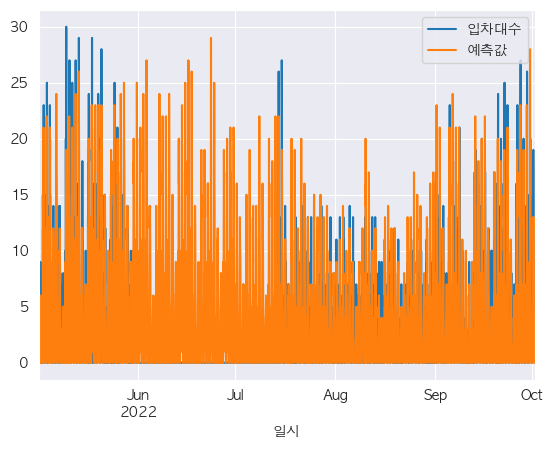

In [141]:
pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1).plot()

In [142]:
result = pd.concat([test_y, pd.Series(predict_test, index=test_y.index, name='예측값')], axis=1)
result['차이'] = abs(result['입차대수']-result['예측값'])
result

,입차대수,예측값,차이
일시,,,
2022-05-01 01:00:00,0.0,0.0,0.0
2022-05-01 02:00:00,0.0,0.0,0.0
2022-05-01 03:00:00,0.0,0.0,0.0
2022-05-01 04:00:00,0.0,0.0,0.0
2022-05-01 05:00:00,0.0,0.0,0.0
...,...,...,...
2022-10-01 19:00:00,3.0,1.0,2.0
2022-10-01 20:00:00,1.0,0.0,1.0
2022-10-01 21:00:00,1.0,0.0,1.0


In [145]:
result[result['입차대수']>=5]

,입차대수,예측값,차이
일시,,,
2022-05-01 12:00:00,5.0,4.0,1.0
2022-05-01 13:00:00,9.0,5.0,4.0
2022-05-01 15:00:00,8.0,5.0,3.0
2022-05-01 16:00:00,6.0,5.0,1.0
2022-05-01 17:00:00,7.0,4.0,3.0
...,...,...,...
2022-10-01 13:00:00,19.0,12.0,7.0
2022-10-01 14:00:00,11.0,13.0,2.0
2022-10-01 15:00:00,9.0,11.0,2.0


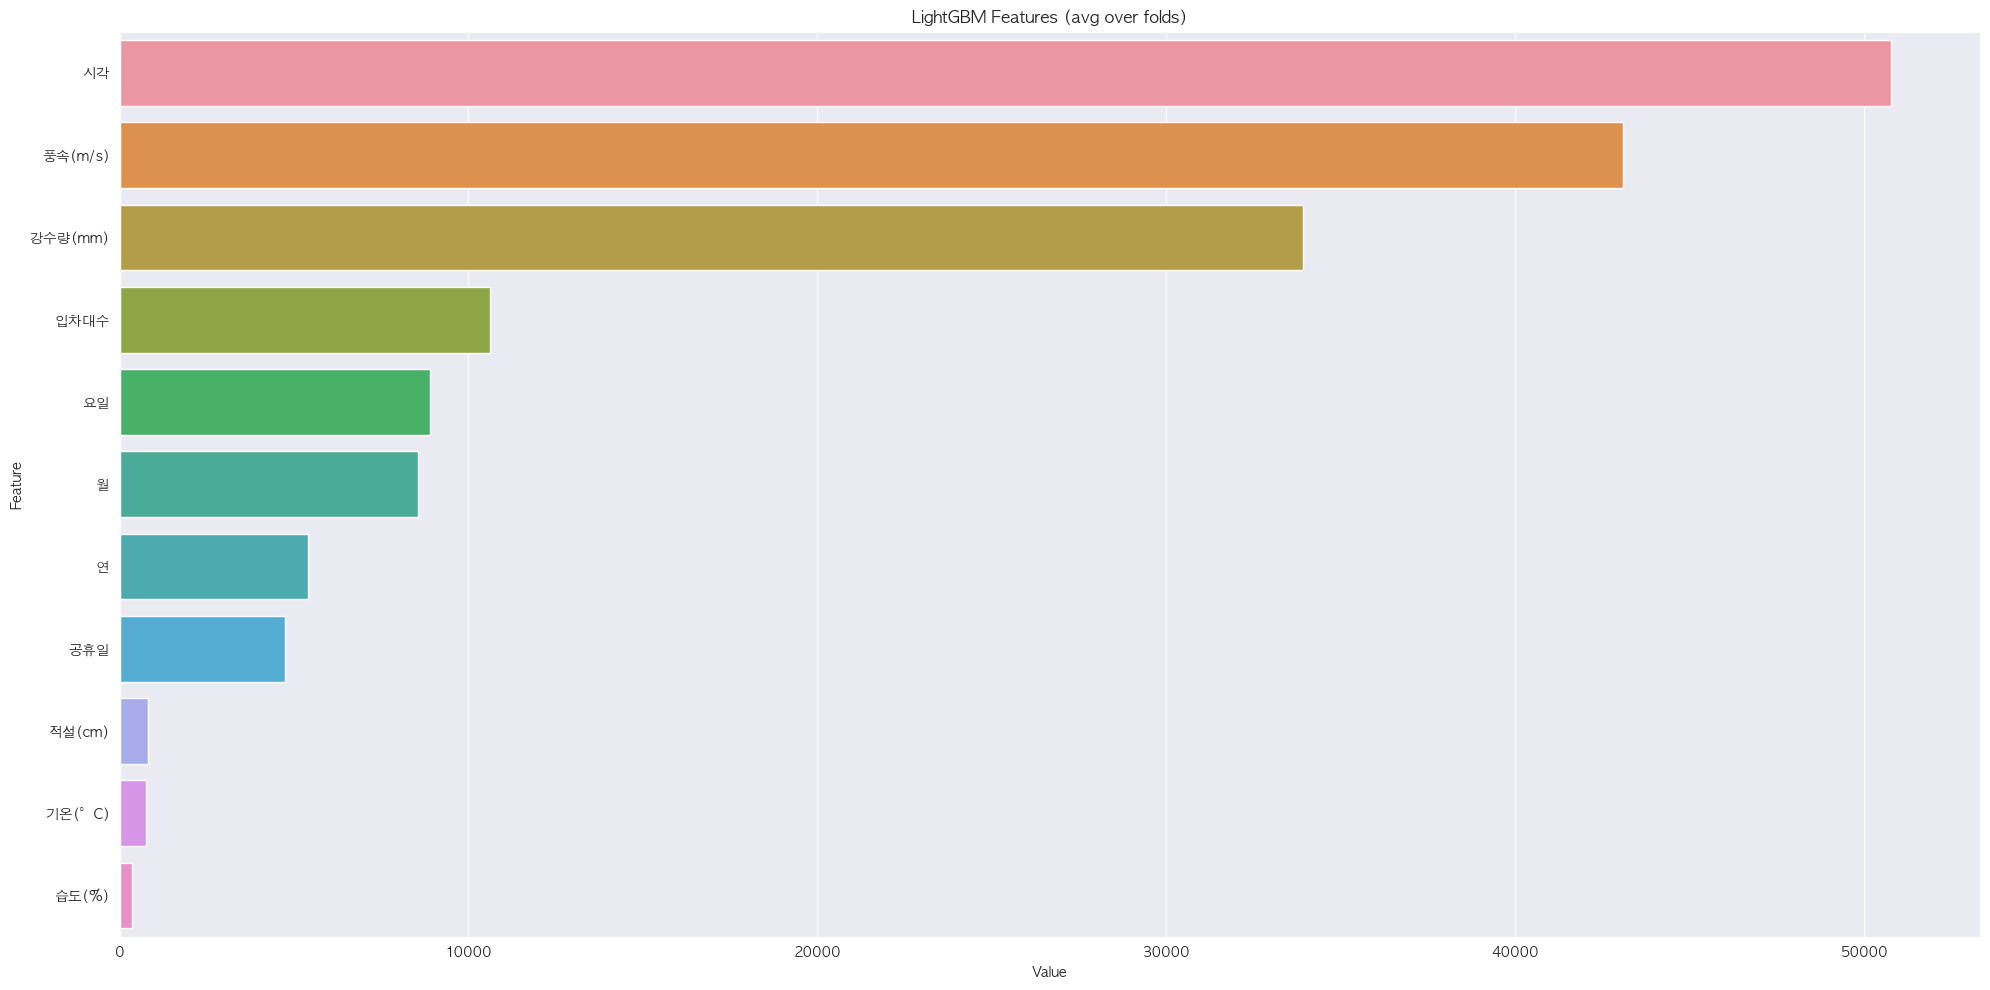

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,dataset.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()